In [1]:
import numpy as np
from IPython.core.debugger import set_trace
import re
import difflib
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests
import time
import random
import pickle
from lxml.html import fromstring
from collections import Counter
from requests.packages.urllib3.util import Retry
from requests.adapters import HTTPAdapter
from requests import Session, exceptions
import sys
import pymongo
from pymongo import MongoClient
from newspaper import Article
import json
from string import digits
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
from nltk.stem.porter import *
from collections import Counter 
from nltk.corpus import wordnet # To get words in dictionary with their parts of speech
from nltk.stem import WordNetLemmatizer # lemmatizes word based on it's parts of speech
from nltk.corpus import stopwords 
from textblob import TextBlob
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import cmudict
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from langdetect import detect
from numpy import dot
from numpy.linalg import norm
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
sys.path.append("/Users/rohanramesh/Documents/GitHub/Insight_writers/lib/")
from text_processing import ProcessArticle as pa
import suggestions as s

In [8]:
# normalize new df
def normalize_df(df):
    result = df.copy()
    for feature_name in df.columns:
        if isinstance(df[feature_name][0], str):
            continue
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
#         result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        result[feature_name] = (df[feature_name] - df[feature_name].mean()) / (df[feature_name].std())
#         result[feature_name] = (df[feature_name]) / norm(df[feature_name])
    return result

# same normalization but on vector
def normalize_vec(list1, means, var):
    output_vec = [(list1[i]-means[i])/var[i] for i in range(0,len(list1))]
    return output_vec

def cos_sim(vec1,vec2):
    a = dot(vec1, vec2)/(norm(vec1)*norm(vec2))
    return a

def give_author_suggestion_from_author(writer_feature_subsection, author):
    norm_feature_df = normalize_df(writer_feature_subsection)
    authors = norm_feature_df['author_list'].tolist()
    if author not in authors:
        return 'blah'
    else:
        idx = authors.index(author)
        norm_vec = norm_feature_df.iloc[idx][:-1]
        # do similarity test
        similarity_vec = []
        for i in range(0,len(authors)):
            vec1 = norm_feature_df.iloc[i,:-1].values
            result1 = cos_sim(vec1, norm_vec)
            similarity_vec.append(round(result1*10,2)) # multiply bu 10 to scale
        tdf = pd.DataFrame.from_dict({'similarity': similarity_vec, 'authors': authors})
        output_df = tdf.sort_values(by='similarity', ascending=False)
        return output_df

In [2]:
# data load from muckrack
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/Attempt3_mr_scrape.pickle', 'rb') as handle:
    scrapevar = pickle.load(handle)
    
# load writer df
with open('/Users/rohanramesh/Documents/Insight/data_bball_writers/writer_df.pickle', 'rb') as handle:
    writer_df = pickle.load(handle)

In [3]:
# Establish connection with database for individual article content
client = MongoClient()
mydb = client["testinsightdb"]

In [4]:
# establish connection for writer feature db
dbname = 'writer_feature_db'
username = 'rohanramesh' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))
con = None
con = psycopg2.connect(database = dbname, user = username)

postgres://rohanramesh@localhost/writer_feature_db
True


In [5]:
# pull from database about writer features
sql_query = """
SELECT AVG("n_words") AS "avg_n_words",
         AVG("neg_sent") AS "avg_neg_sent",
         AVG("neu_sent") AS "avg_neu_sent",
         AVG("pos_sent") AS "avg_pos_sent",
         AVG("neg_sent_var") AS "avg_neg_sent_var",
         AVG("neu_sent_var") AS "avg_neu_sent_var",
         AVG("pos_sent_var") AS "avg_pos_sent_var",
        AVG("n_sentences") AS "avg_n_sentences",
        AVG("n_wordspersentence") AS "avg_n_wordspersentence",
        AVG("n_wordspersent_variability") AS "avg_n_wordspersent_variability",
        AVG("wordlength") AS "avg_wordlength",
        AVG("wordlength_var") AS "avg_wordlength_var",
        AVG("wordlength_skew") AS "avg_wordlength_skew",
        "author_list"
FROM writer_feature
WHERE "n_words" > 100
GROUP BY "author_list"
HAVING COUNT(*) > 25 
ORDER BY AVG("n_words") DESC
"""
writer_feature_subsection = pd.read_sql_query(sql_query,con)
writer_feature_subsection.head(10)
writer_feature_subsection.replace([np.inf, -np.inf], np.nan)
writer_feature_subsection = writer_feature_subsection.dropna(axis=0, how='any')
norm_writer_feature_subsection = s.normalize_df(writer_feature_subsection)

In [11]:
writer_feature_subsection.keys()

Index(['avg_n_words', 'avg_neg_sent', 'avg_neu_sent', 'avg_pos_sent',
       'avg_neg_sent_var', 'avg_neu_sent_var', 'avg_pos_sent_var',
       'avg_n_sentences', 'avg_n_wordspersentence',
       'avg_n_wordspersent_variability', 'avg_wordlength',
       'avg_wordlength_var', 'avg_wordlength_skew', 'author_list'],
      dtype='object')

In [22]:
# build db for writer rankings
writer_rankings_df = pd.read_csv('/Users/rohanramesh/Documents/Insight/data_bball_writers/writers.csv')
writer_rankings_df.head()
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))
# writer_rankings_df.to_sql('writer_rankings', engine, if_exists='replace')

True


In [7]:
# get from writer rankings
sql_query = """
SELECT *
FROM writer_rankings
"""
writer_rankings_subsection = pd.read_sql_query(sql_query,con)
writer_rankings_subsection.head()

,index,Wikisurvey ID,Idea ID,Idea Text,Wins,Losses,Times involved in Cant Decide,Score,User Submitted,Session ID,Created at,Last Activity,Active,Appearances on Left,Appearances on Right,Info
0,0,11361,693716,Zach Lowe,2951,288,100,91.0830,False,5012316,2017-09-13 15:28:25 UTC,2017-10-03 01:44:17 UTC,True,1821,1908,None
1,1,11361,693715,Adrian Wojnarowski,2457,732,118,77.0291,False,5012316,2017-09-13 15:28:25 UTC,2017-10-03 01:40:16 UTC,True,1855,1835,None
2,2,11361,693742,Lee Jenkins,2421,746,260,76.4279,False,5012316,2017-09-13 15:28:26 UTC,2017-10-03 01:43:04 UTC,True,1917,1841,None
3,3,11361,693755,Howard Beck,2425,748,186,76.4094,False,5012316,2017-09-13 15:28:26 UTC,2017-10-03 01:44:13 UTC,True,1839,1864,None
4,4,11361,693719,Marc Stein,2426,759,120,76.1531,False,5012316,2017-09-13 15:28:26 UTC,2017-10-03 01:44:11 UTC,True,1788,1898,None


In [8]:
# need to look at difference in ranking vs cossim
# first need to translate the orderered website names to real names

webnames = writer_df['website_name'].tolist()
realnames = writer_df['Idea Text'].tolist()
authorlist_no_web_ordered = [realnames[webnames.index(i)] for i in authorlist]
# calculate the cos sim and popularity
nvals = len(authorlist)
matsim_feat = np.ndarray(shape=(nvals,nvals))
matrankdiff = np.ndarray(shape=(nvals,nvals))
for i in range(0,nvals):
    author1 = authorlist_no_web_ordered[i]
    idx_i = writer_rankings_subsection['Idea Text'].tolist().index(author1)
    for j in range(0,nvals):
        author2 = authorlist_no_web_ordered[j]
        # for cos sim
        vec1 = norm_writer_feature_subsection.iloc[i,:-1].values
        vec2 = norm_writer_feature_subsection.iloc[j,:-1].values
        result1 = cos_sim(vec1, vec2)
        matsim_feat[i, j] = result1
        # lets also do difference in index = ranking
        idx_i = writer_rankings_subsection['Idea Text'].tolist().index(author1)
        idx_j = writer_rankings_subsection['Idea Text'].tolist().index(author2)
        matrankdiff[i,j] = abs(writer_rankings_subsection[
            'index'].iloc[idx_i] - writer_rankings_subsection['index'].iloc[idx_j])

In [9]:
corr_comp_cossim_diff = []
for i in range(0,nvals):
    for j in range(i+1,nvals):
        corr_comp_cossim_diff.append([matsim_feat[i,j], matrankdiff[i,j]])
        
matsim_vec = [corr_comp_cossim_diff[i][0] for i in range(0,np.shape(corr_comp_cossim_diff)[0])]
matrank_vec = [corr_comp_cossim_diff[i][1] for i in range(0,np.shape(corr_comp_cossim_diff)[0])]

[50.351724137931036, 33.44878350130246]
[44.944839857651246, 31.096317195510803]
[45.56, 32.57120200422453]
[42.73900293255132, 31.30924981427282]
[44.476190476190474, 30.618280895297282]
[42.68372093023256, 30.42743251936597]
[46.488069414316705, 32.809024219602605]
[35.45029239766082, 27.210714208759036]


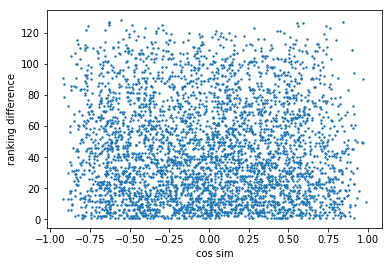

In [10]:
plt.scatter(matsim_vec, matrank_vec, s=2)
plt.xlabel('cos sim')
plt.ylabel('ranking difference')

bins_use = np.linspace(-1,1,9)
for i in range(0,len(bins_use)-1):
    r = [matrank_vec[j] for j in range(0,len(matsim_vec)) if 
         (matsim_vec[j] > bins_use[i]) & (matsim_vec[j] < bins_use[i+1])]
    print([np.mean(r), np.std(r)])
    
first_5_ranking_diff = []
rest_ranking_dff = []
for curr_name in authorlist:
    a = give_author_suggestion_from_author(writer_feature_subsection, curr_name)
#     print(a.head())
    # make list of authors
    rank_auth = [authorlist.index(i) for i in a['authors'].tolist()]
    # print(rank_auth[0:5])
    # plt.plot(matrankdiff[authorlist.index(curr_name),rank_auth])
    first_5_ranking_diff.append(np.mean(matrankdiff[authorlist.index(curr_name),rank_auth[1:3]]))
    rest_ranking_dff.append(np.mean(matrankdiff[authorlist.index(curr_name),rank_auth[4:]]))

In [5]:
# lets load in individual votes and push to db
# build db for writer rankings
writer_h2h_df = pd.read_csv('/Users/rohanramesh/Documents/Insight/data_bball_writers/votes.csv')
# print(writer_h2h_df.head())
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))
# writer_h2h_df.to_sql('writer_h2h', engine, if_exists='replace')


True


In [12]:
# curr_name2 = 'Zach Lowe'
# curr_name1 = 'Lee Jenkins'
win_loss_h2h = {}
for i in range(0,nvals):
    curr_name1 = authorlist_no_web_ordered[i]
    win_loss_h2h[curr_name1] = {}
    for j in range(0,nvals):
        curr_name2 = authorlist_no_web_ordered[j]
        idx_win1 = (writer_h2h_df['Winner Text'] == curr_name1) & (writer_h2h_df['Loser Text'] == curr_name2)
        idx_win2 = (writer_h2h_df['Winner Text'] == curr_name2) & (writer_h2h_df['Loser Text'] == curr_name1)
        win_loss_h2h[curr_name1][curr_name2] = [len(np.where(idx_win1)[0]), len(np.where(idx_win2)[0])]

In [15]:
print(authorlist[0:5])
print(authorlist_no_web_ordered[0:5])

['steve-kyler', 'chris-ballard', 'lee-jenkins', 'dennis-chambers', 'jared-zwerling']
['Steve Kyler', 'Chris Ballard', 'Lee Jenkins', 'Dennis Chambers', 'Jared Zwerling']


In [63]:
nrank_take = 5
ranking_diff = []
rest_ranking_dff = []
# ii = 3
for ii in range(0,len(authorlist)):
    curr_name = authorlist[ii]
    a = give_author_suggestion_from_author(writer_feature_subsection, curr_name)
    # make list of authors
    rank_auth = [authorlist.index(i) for i in a['authors'].tolist()]
    # translate to full authornames
    rank_auth2 = [authorlist_no_web_ordered[i] for i in rank_auth]
    tmpranking = []
    for r in range(1,nrank_take):
        curr_pair = win_loss_h2h[authorlist_no_web_ordered[ii]][rank_auth2[r]]
        tmpranking.append(abs(curr_pair[1]-curr_pair[0])/np.sum(curr_pair))
    ranking_diff.append(np.median(tmpranking))
    for r in range(nrank_take+1,len(authorlist)):
        curr_pair = win_loss_h2h[authorlist_no_web_ordered[ii]][rank_auth2[r]]
        tmpranking.append(abs(curr_pair[1]-curr_pair[0])/np.sum(curr_pair))
    rest_ranking_dff.append(np.median(tmpranking[nrank_take+1:-1]))

    # plt.plot(matrankdiff[authorlist.index(curr_name),rank_auth])
#     first_5_ranking_diff.append(np.mean(matrankdiff[authorlist.index(curr_name),rank_auth[1:3]]))
#     rest_ranking_dff.append(np.mean(matrankdiff[authorlist.index(curr_name),rank_auth[4:]]))

Look at how dividing article in half vs grabbing random article affects classification based on writer style or content

In [9]:
# load word2vec model
kv = gensim.models.KeyedVectors.load(
    "/Users/rohanramesh/Documents/Insight/data_bball_writers/word2vec_model_kv.kv", mmap='r')
# load word2vec df for comparisons
w2v_df = pd.read_pickle('/Users/rohanramesh/Documents/Insight/data_bball_writers/word2vec_trained.pickle')


In [20]:
def lemstr(txtstr):
    """
    Lemmatize text string
    :param writer_feature_subsection: df that has each row for an author and each column a feature
    :param author: author name
    :return:
    """
    lz = WordNetLemmatizer()
    newstr = [lz.lemmatize(curr_word, pa.get_pos(curr_word)) for curr_word in txtstr]
    return newstr

def cos_sim(vec1,vec2):
    """
    Calculate cosine similarity between 2 vectors
    """
    a = dot(vec1, vec2)/(norm(vec1)*norm(vec2))
    return a

def compare_content_two_articles(keyedvectors, w2v_df, article1, article2):
    lem_art1 = lemstr(gensim.utils.simple_preprocess(article1))
    lem_art2 = lemstr(gensim.utils.simple_preprocess(article2))
    article_vector1 = get_vector_from_w2v_model(keyedvectors, lem_art1)
    article_vector2 = get_vector_from_w2v_model(keyedvectors, lem_art2)
    sim = cos_sim(article_vector1, article_vector2)
    return sim

def compare_style_two_articles(article1, article2, writer_feature_subsection):
    curr1 = pa(article1)
    vec1 = curr1.build_feature_vector_for_article()
    norm_vec1 = normalize_vec(vec1, writer_feature_subsection.mean().tolist(),
                             writer_feature_subsection.std().tolist())
    curr2 = pa(article2)
    vec2 = curr2.build_feature_vector_for_article()
    norm_vec2 = normalize_vec(vec2, writer_feature_subsection.mean().tolist(),
                             writer_feature_subsection.std().tolist())
    sim = cos_sim(norm_vec1, norm_vec2)
    return sim

    
def get_vector_from_w2v_model(keyedvectors, txtstr):
    """
    Given a url from an article suggest other articles with similar content due to w2v
    :param keyedvectors: low dimensional vectors from word2vec model
    :param txtsr: text from article
    :return: vector representation of article
    """
    a = [r for r in txtstr if r in keyedvectors.vocab]
    array_for_art = np.ndarray(shape=[len(a),keyedvectors.vector_size])
    for i in range(0,len(a)):
        array_for_art[i,:] = keyedvectors[a[i]]
    article_vector = np.mean(array_for_art, axis=0)
    return article_vector

# same normalization but on vector
def normalize_vec(list1, means, var):
    """
    normalize a list
    :param list1: list to be normalized
    :param means: vector of means
    :param var: vector of std
    :return:
    """
    output_vec = [(list1[i]-means[i])/var[i] for i in range(0,len(list1))]
    return output_vec

In [ ]:
authorlist = norm_writer_feature_subsection['author_list'].tolist()
n_articles_test = 50
n_articles_comp = 50
n_boot_comp = 100
similarity_within_author = {}
baseline_across_author = {}
for ii in range(0,np.shape(writer_df)[0]):
    curr_name = writer_df['website_name'][ii]
    curr_name_full = writer_df['Idea Text'][ii]
    print(curr_name)
    t = time.time()
    currcol = mydb[curr_name]
    y = currcol.find({"name": curr_name})
    totalarticlen = y.count()
    if totalarticlen < 25:
        continue
    similarity_within_author[curr_name] = {}
    baseline_across_author[curr_name] = {}
    content_sim = []
    style_sim = []
    for jj in range(0, n_boot_comp):
        curr_idx = random.sample(range(0,totalarticlen),1)
        curr_article = y[curr_idx[0]]['article']
        tokens = word_tokenize(curr_article)
        if len(tokens) < 50: # if fewer than 50 words don't bother
            continue
        # split article in half - not worrying right now about cutting words in half
        first_half = curr_article[0:int(np.floor(len(curr_article)/2))]
        second_half = curr_article[int(np.floor(len(curr_article)/2)):]
        # calculate similarity between first and second half
        content_sim.append(compare_content_two_articles(kv, w2v_df, first_half, second_half))
        style_sim.append(compare_style_two_articles(first_half, second_half, writer_feature_subsection))
    similarity_within_author[curr_name]['content'] = content_sim
    similarity_within_author[curr_name]['style'] = style_sim    
    # now for baseline testing
    baseline_style = []
    baseline_content = []
    for j in range(0,n_boot_comp):
        new_author = random.sample(writer_df['website_name'].tolist(), 1)[0]
        currcol2 = mydb[new_author]
        y2 = currcol2.find({"name": new_author})
        totalarticlen = y2.count()
        if totalarticlen == 0:
            continue
        curr_idx = random.sample(range(0,totalarticlen),1)
        curr_article2 = y2[curr_idx[0]]['article']
        # now do comps for first and second half
        baseline_content.append(compare_content_two_articles(kv, w2v_df, first_half, curr_article2))
        baseline_style.append(compare_style_two_articles(first_half, curr_article2, writer_feature_subsection))
        baseline_content.append(compare_content_two_articles(kv, w2v_df, second_half, curr_article2))
        baseline_style.append(compare_style_two_articles(second_half, curr_article2, writer_feature_subsection))
    baseline_across_author[curr_name]['content'] = baseline_content
    baseline_across_author[curr_name]['style'] = baseline_style   


zachlowe_nba


/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  
/anaconda3/envs/insight_new/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepd

adrian-wojnarowski
lee-jenkins
howardbeck
marc-stein
ethan-sherwood-strauss
jason-concepcion
kevin-arnovitz
tom-haberstroh
nate-duncan
zach-harper
brian-windhorst
sam_amick
david-aldridge
ramona-shelburne
jpdabrams
kevin-pelton
marc-j-spears
matt-moore
shams-charania
kevin-p-oconnor
chris-haynes
dave-mcmenamin
shea-serrano
ian-begley
rachel-nichols
ben-golliver
mike-prada
robmahoney
tim-macmahon
chris-herring
billsimmons
jonathan-tjarks
amin-elhassen
bobby-marks
danny-leroux
chris-mannix
dan-devine
michael-pina
thompsonscribe
ben-golliver
ben-falk
ian-levy
tim-bontemps
henry-abbott
scott-rafferty
ja-dubin
michael-lee
alex-kennedy
derek-bodner
tom-ziller
chris-ballard
josh-eberley
adi-joseph
adam-mares
sam-vecenie
meet-katie-nolan
andrew-sharp
david-thorpe
royce-webb
ericpincus
nick-sciria
paul-flannery
timkawakami
keith-smith
joshrobbins
jeff-zillgitt
jon-krawczynski
seerat-sohi
israel-gutierrez
ben-rohrbach
mika-honkasalo
ian-oconnor-1027184
kevin-ferrigan
chris-vernon
trevor-magnotti

In [49]:
rr = writer_df['website_name'].tolist()
rr.index('amin-elhassen')
for i in range(33,34):
    print(i)

33


In [51]:
print(np.nanmean(content_sim))
print(np.nanmean(style_sim))
print(np.nanmean(baseline_content))
print(np.nanmean(baseline_style))

0.8429008206707249
0.2959325217782179
0.45411984147612233
0.04099638822069874


In [58]:
tmpR = 'zachlowe_nba'
print(np.nanmean(baseline_across_author[tmpR]['content']))
print(np.nanmean(similarity_within_author[tmpR]['content']))
print(np.nanmean(baseline_across_author[tmpR]['style']))
print(np.nanmean(similarity_within_author[tmpR]['style']))

0.7039741826387454
0.9106749535955404
-0.024108854120058903
0.6175859371203857


In [71]:
tmpauthorlist = similarity_within_author.keys()
style_sim_within = []
style_sim_across = []
content_sim_within = []
content_sim_across = []
for ii in similarity_within_author:
    try:
        content_sim_across.append(np.nanmedian(baseline_across_author[ii]['content']))
        content_sim_within.append(np.nanmedian(similarity_within_author[ii]['content']))
        style_sim_across.append(np.nanmedian(baseline_across_author[ii]['style']))
        style_sim_within.append(np.nanmedian(similarity_within_author[ii]['style']))
    except:
        print(ii)

amin-elhassen
ja-dubin
royce-webb
jeff-zillgitt
jon-krawczynski
sam-esfandiari
jade-hoye
ric-bucher
senthil-natarajan
kaileigh-brandt
trill-withers
scott-cacciola
albert-nahmad
david-morrow
peter-vecsey
george-rowland
editor-dan
ti-windisch
glory-okoli
aaron-bruski
paul-centopani
stephen-a-smith
andré-voigt
skip-bayless
seb-dumitru


/anaconda3/envs/insight_new/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [73]:
print(np.nanmean(content_sim_across))
print(np.nanmean(content_sim_within))
print(np.nanmean(style_sim_across))
print(np.nanmean(style_sim_within))

0.599661788548802
0.8388880930924403
0.028184486626333535
0.4689644620952276


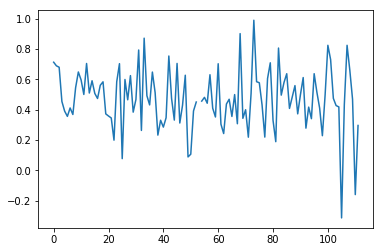

In [74]:
plt.plot(style_sim_within)